# Install dependencies

In [1]:
# Install deps

%pip install internetarchive split-folders ultralytics paddlepaddle paddleocr deep-sort-realtime

Note: you may need to restart the kernel to use updated packages.


# Download dataset and split it

In [ ]:
from internetarchive import download

# Download dataset
download("anpr-dataset", files=["anpr-dataset.tar.gz"], verbose=True, no_directory=True) # type: ignore

In [3]:
# Unpack dataset
import tarfile

with tarfile.open("anpr-dataset.tar.gz") as tar:
    tar.extractall("anpr-dataset")

In [2]:
# List files
from glob import glob
import pandas as pd
    
dataset_files = glob('anpr-dataset/labeled_images/images/*.jpg')
df = pd.DataFrame(data={'File': dataset_files})
df

,File
0,anpr-dataset/labeled_images/images/CarLongPlat...
1,anpr-dataset/labeled_images/images/video11_208...
2,anpr-dataset/labeled_images/images/CarLongPlat...
3,anpr-dataset/labeled_images/images/CarLongPlat...
4,anpr-dataset/labeled_images/images/xemay2128_j...
...,...
28670,anpr-dataset/labeled_images/images/CarLongPlat...
28671,anpr-dataset/labeled_images/images/Cars14_png_...
28672,anpr-dataset/labeled_images/images/rotatequand...
28673,anpr-dataset/labeled_images/images/CarLongPlat...


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_images(images, width, height, columns=2, rows=3):
    fig = plt.figure(figsize=(width, height))
    for i, file in enumerate(images):
        img = plt.imread(file)
        fig.add_subplot(rows, columns, i + 1)
        plt.imshow(img)
    plt.show()

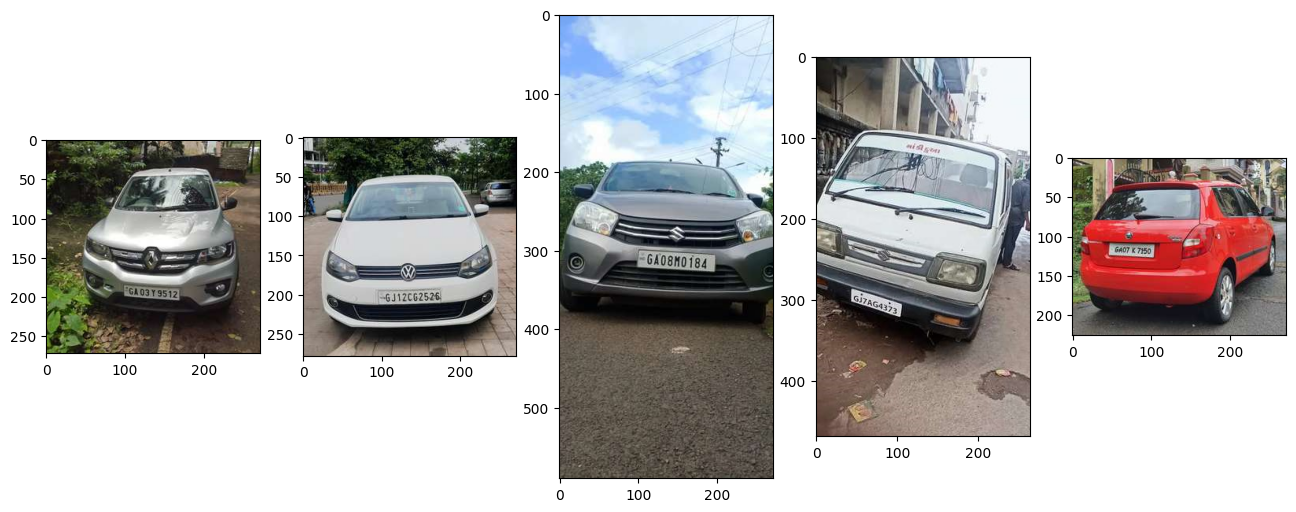

In [5]:
# Show sample

dataset_sample = glob('anpr-dataset/labeled_images/images/G*.jpg')[:5]

plot_images(dataset_sample, width=16, height=8, columns=5, rows=1)

In [ ]:
import splitfolders

# split into 80% train, 10% val, 10% test

splitfolders.ratio('anpr-dataset/labeled_images', output='anpr-dataset', seed=420, ratio=(0.8, 0.1, 0.1))

# Training

In [6]:
EPOCHS = 50
BATCH_SIZE = 8
IMAGE_RESOLUTION = 640

In [ ]:
from ultralytics import YOLO

# Load the pretrained model
model = YOLO('yolov8x.pt')

In [ ]:
# Training the model
results = model.train(
   data='anpr-dataset/data.yaml',
   imgsz=IMAGE_RESOLUTION,
   epochs=EPOCHS,
   batch=BATCH_SIZE,
   name='yolov8x_anpr'
)

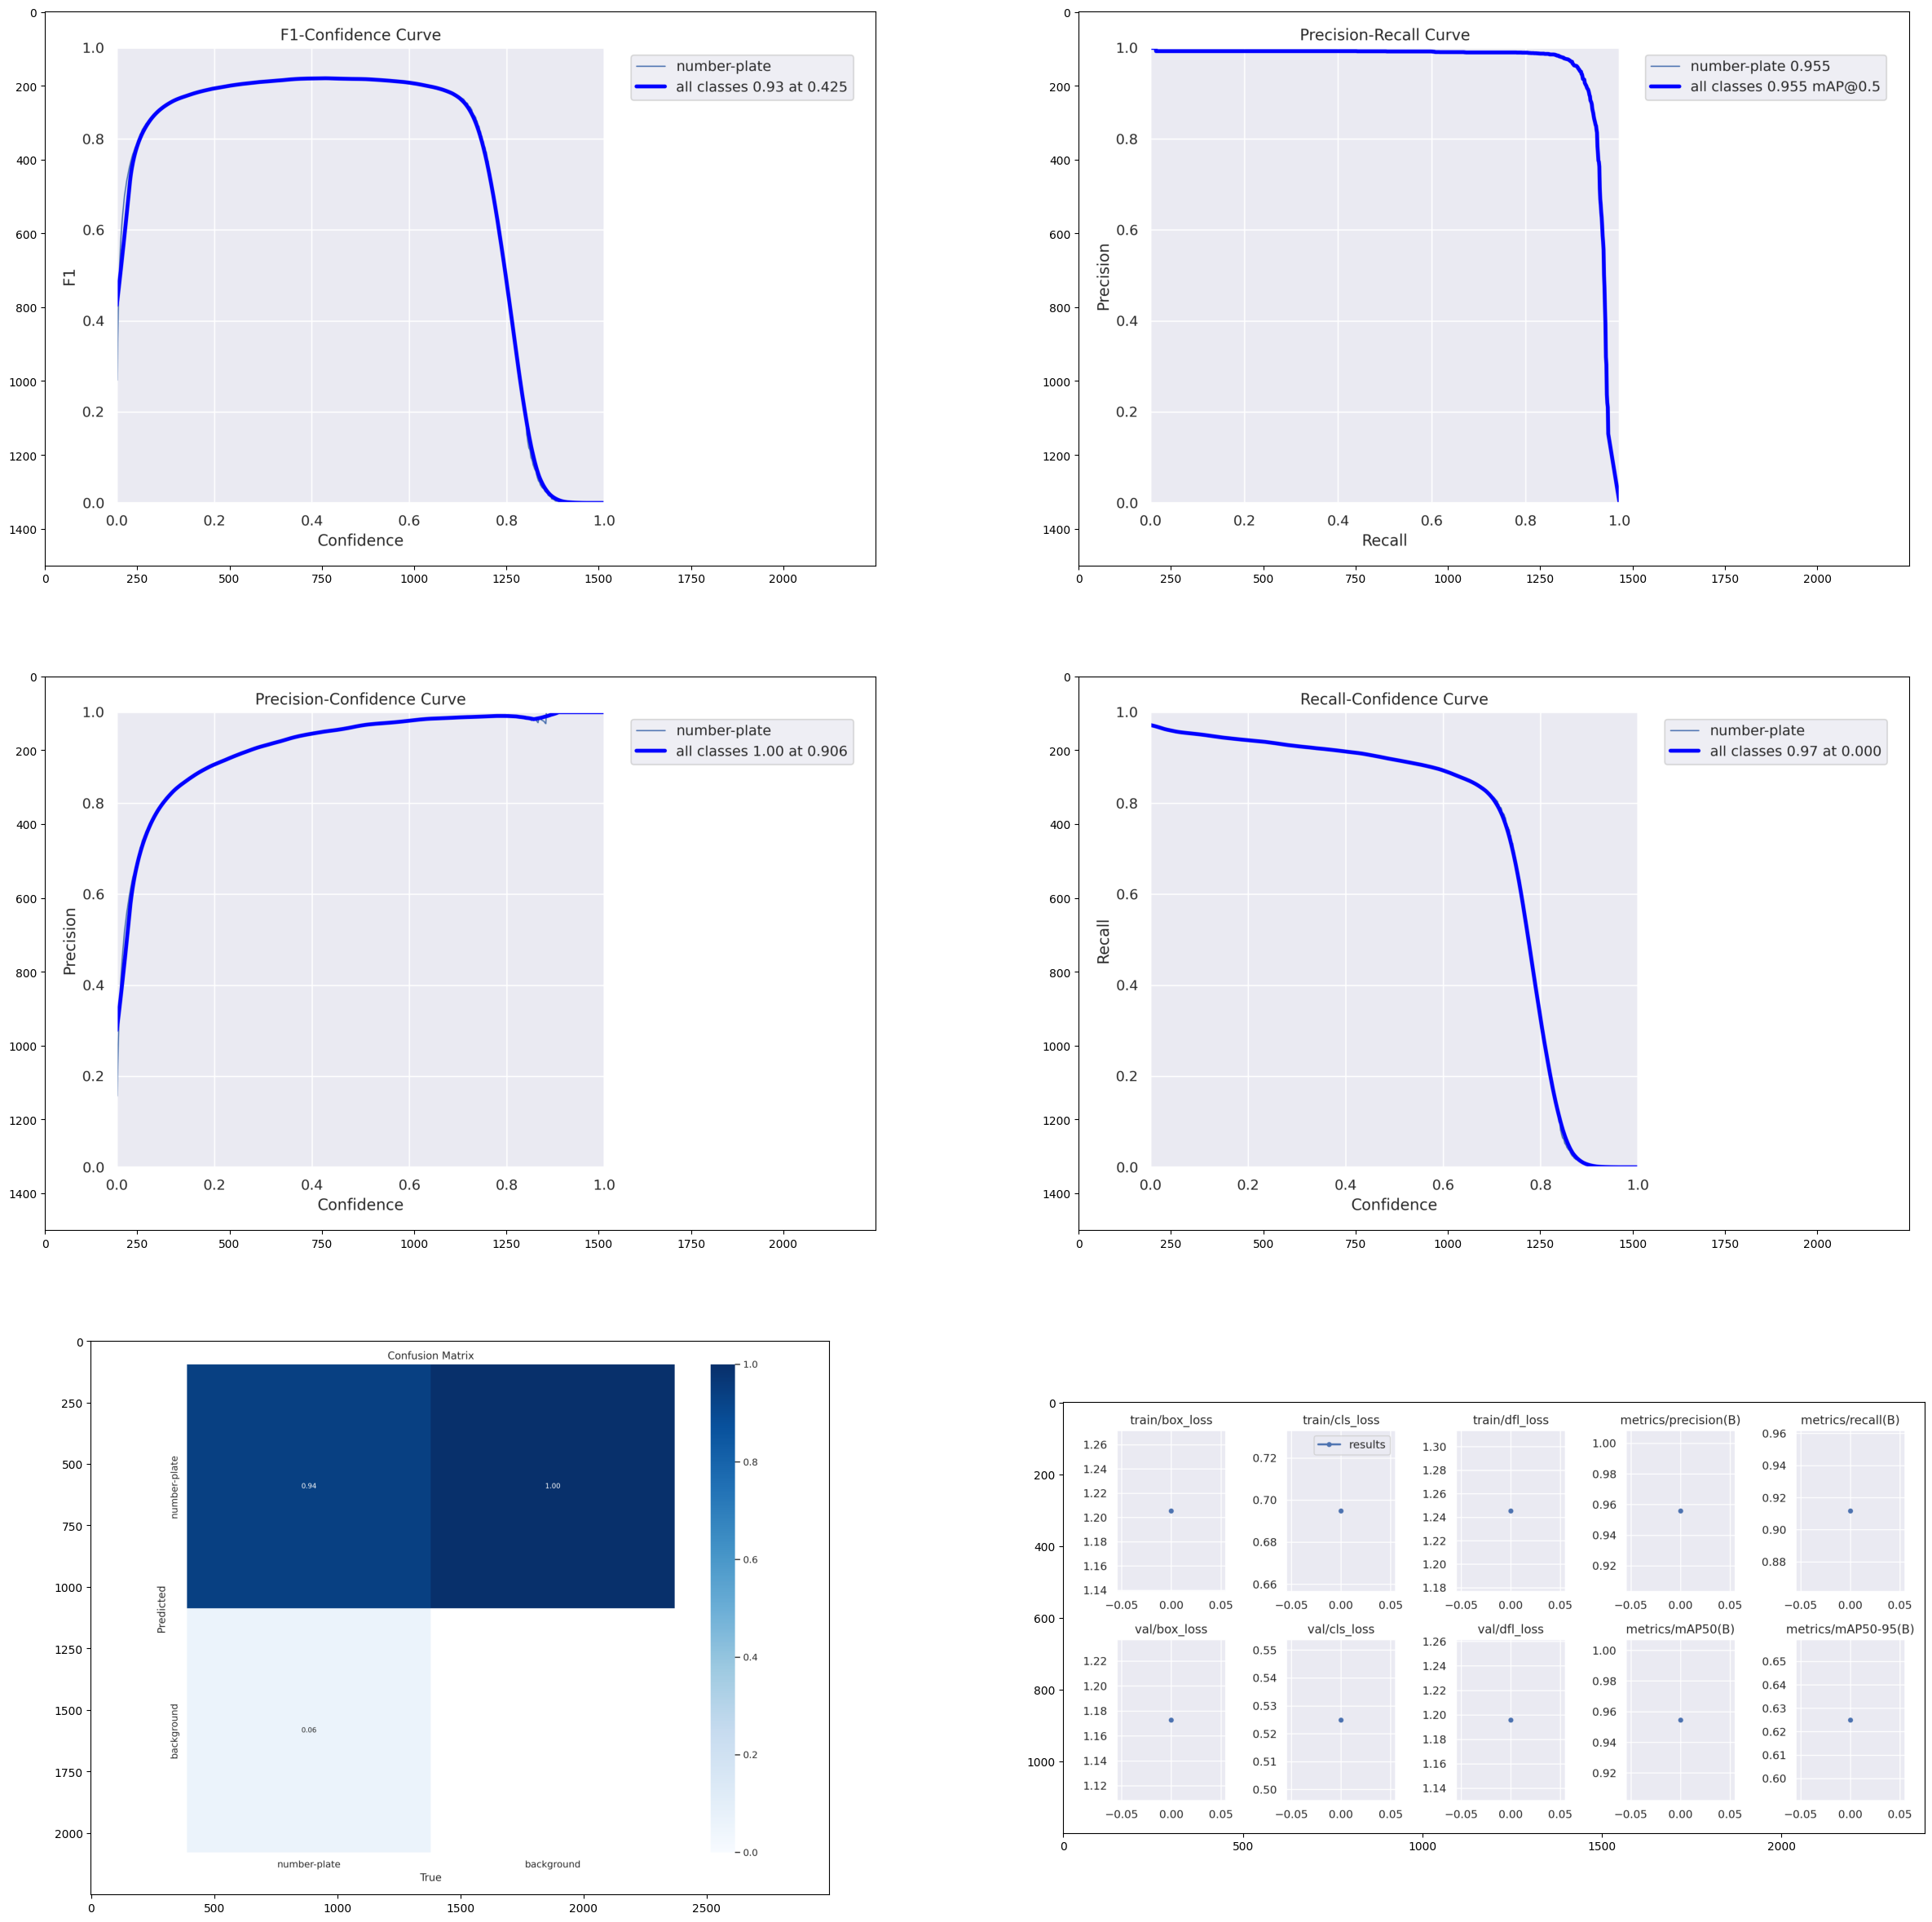

                  epoch,         train/box_loss,         train/cls_loss,         train/dfl_loss,   metrics/precision(B),      metrics/recall(B),       metrics/mAP50(B),    metrics/mAP50-95(B),           val/box_loss,           val/cls_loss,           val/dfl_loss,                 lr/pg0,                 lr/pg1,                 lr/pg2
                      0,                 1.2055,                 0.6949,                 1.2455,                0.95595,                 0.9118,                0.95463,                0.62503,                 1.1728,                0.52496,                 1.1959,                0.07001,              0.0033322,              0.0033322



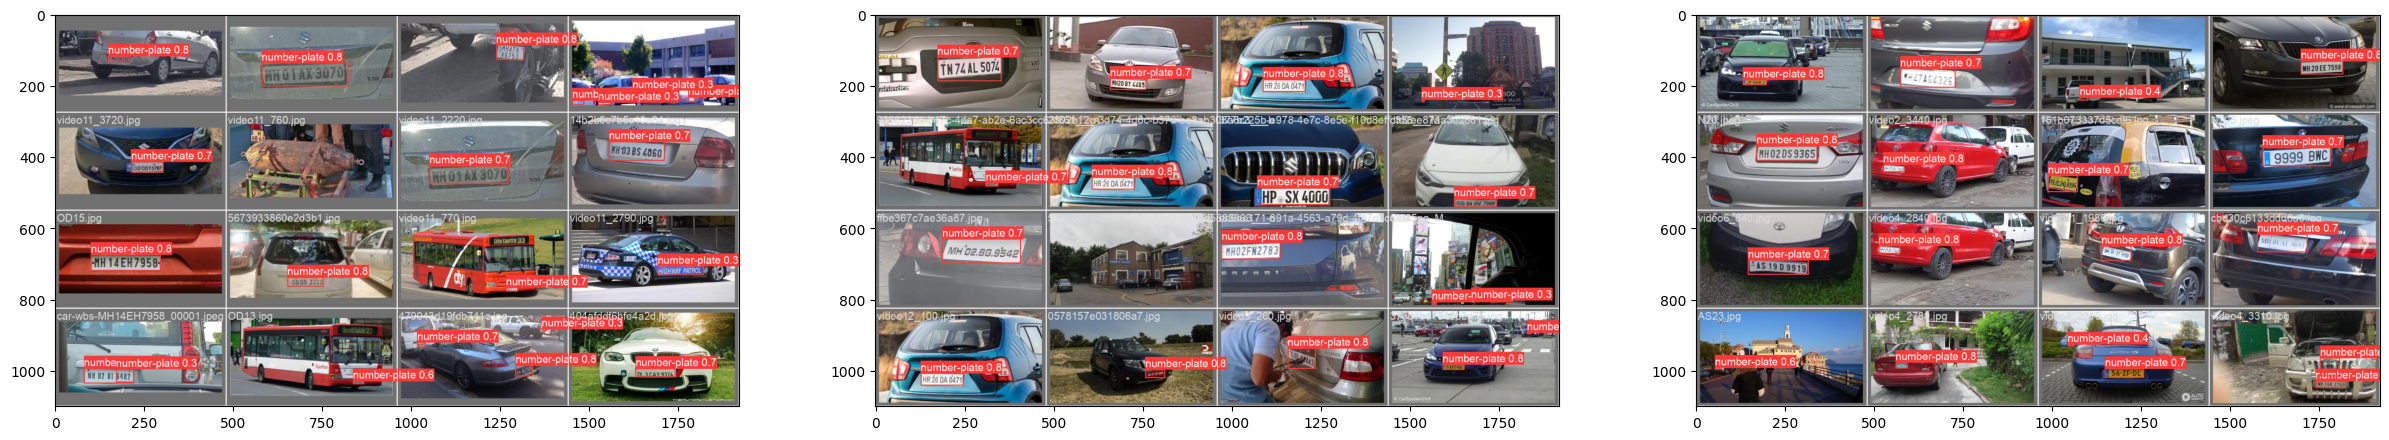

In [7]:
# Show results

model_path = './runs/detect/anpr_model2'

curves = [f'{model_path}/F1_curve.png', f'{model_path}/PR_curve.png', f'{model_path}/P_curve.png', f'{model_path}/R_curve.png', f'{model_path}/confusion_matrix.png', f'{model_path}/results.png']

plot_images(curves, width=30, height=30, columns=2, rows=3)

with open(f'{model_path}/results.csv') as f:
    file_contents = f.read()
    print(file_contents)

test_batch = [f'{model_path}/val_batch0_pred.jpg', f'{model_path}/val_batch1_pred.jpg', f'{model_path}/val_batch2_pred.jpg']
plot_images(test_batch, width=30, height=30, columns=3, rows=1)

# Testing

## Load the model

In [2]:
from paddleocr import PaddleOCR
from ultralytics import YOLO

model = YOLO(model='./runs/detect/anpr_model2/weights/best.pt', task='detect')

paddle = PaddleOCR(lang="en", use_angle_cls=True, show_log=False)

[2023/03/05 01:52:08] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/home/attka/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/home/attka/.paddleocr/whl/rec/en/en_PP-OCRv3_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_length=25, rec_char_dict_path

## Make the detection function

In [3]:
import cv2
import numpy as np
import re

def detect_plates(src):
    predictions = model.predict(src, verbose=False)

    results = []

    for prediction in predictions:
        for box in prediction.boxes:
            det_confidence = box.conf.item()
            if det_confidence < 0.6:
                continue
            coords = [int(position) for position in (box.xyxy.view(1, 4)).tolist()[0]]
            results.append({"coords": coords, "det_conf": det_confidence})
    
    return results

In [4]:
def crop(img, coords):
    cropped = img[coords[1]:coords[3], coords[0]:coords[2]]
    return cropped

In [5]:
def unsharp_mask(image, kernel_size=(5, 5), sigma=1.0, amount=2.0, threshold=0):
    blurred = cv2.GaussianBlur(image, kernel_size, sigma)
    sharpened = float(amount + 1) * image - float(amount) * blurred
    sharpened = np.maximum(sharpened, np.zeros(sharpened.shape))
    sharpened = np.minimum(sharpened, 255 * np.ones(sharpened.shape))
    sharpened = sharpened.round().astype(np.uint8)
    if threshold > 0:
        low_contrast_mask = np.absolute(image - blurred) < threshold
        np.copyto(sharpened, image, where=low_contrast_mask)
    return sharpened

In [6]:
def ocr_plate(src):
    # Image pre-processing for more accurate OCR
    rescaled = cv2.resize(src, None, fx=1.2, fy=1.2, interpolation=cv2.INTER_CUBIC)
    grayscale = cv2.cvtColor(rescaled, cv2.COLOR_BGR2GRAY)
    kernel = np.ones((1, 1), np.uint8)
    dilated = cv2.dilate(grayscale, kernel, iterations=1)
    eroded = cv2.erode(dilated, kernel, iterations=1)
    sharpened = unsharp_mask(eroded)

    # OCR the preprocessed image
    results = paddle.ocr(sharpened, det=False, cls=True)
    plate_text, ocr_confidence = max(
        results,
        key=lambda ocr_prediction: max(
            ocr_prediction,
            key=lambda ocr_prediction_result: ocr_prediction_result[1],
        ),
    )[0]

    # Filter out anything but uppercase letters, digits, hypens and whitespace.    
    plate_text_filtered = re.sub(r"[^-A-Z0-9 ]", r"", plate_text).strip()
    
    return {"plate": plate_text_filtered, "ocr_conf": ocr_confidence}

In [7]:
def ocr_plates(src, det_predictions):
    results = []

    for det_prediction in det_predictions:
        plate_region = crop(src, det_prediction['coords'])
        ocr_prediction = ocr_plate(plate_region)
        results.append(ocr_prediction)

    return results

In [8]:
def plot_box(img, coords, label=None, color=[0, 150, 255], line_thickness=3):
    # Plots box on image
    c1, c2 = (int(coords[0]), int(coords[1])), (int(coords[2]), int(coords[3]))
    cv2.rectangle(img, c1, c2, color, thickness=line_thickness, lineType=cv2.LINE_AA)
    # Plots label on image, if exists
    if label:
        tf = max(line_thickness - 1, 1)  # font thickness
        t_size = cv2.getTextSize(label, 0, fontScale=line_thickness / 3, thickness=tf)[0]
        c2 = c1[0] + t_size[0], c1[1] - t_size[1] - 3
        cv2.rectangle(img, c1, c2, color, -1, cv2.LINE_AA)  # filled
        cv2.putText(img, label, (c1[0], c1[1] - 2), 0, line_thickness / 3, [225, 255, 255], thickness=tf, lineType=cv2.LINE_AA)

In [9]:
def get_plates(src):
    det_predictions = detect_plates(src)
    ocr_predictions = ocr_plates(src, det_predictions)
    
    for det_prediction, ocr_prediction in zip(det_predictions, ocr_predictions):
        plot_box(src, det_prediction['coords'], ocr_prediction['plate'])

    return src, det_predictions, ocr_predictions

## Test on image

Ultralytics YOLOv8.0.48 🚀 Python-3.10.8 torch-1.13.1+cu117 CUDA:0 (NVIDIA GeForce RTX 3090, 24252MiB)
Model summary (fused): 268 layers, 68124531 parameters, 0 gradients, 257.4 GFLOPs


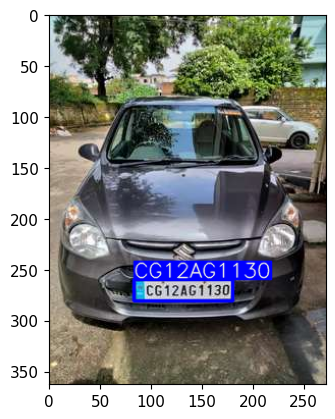

[{'coords': [83, 260, 180, 281], 'det_conf': 0.7455359101295471}] [{'plate': 'CG12AG1130', 'ocr_conf': 0.9054490327835083}]


In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2

test_image = cv2.imread('./anpr_dataset/test/images/CG12.jpg')
detected_image, det_predictions, ocr_predictions = get_plates(test_image)
plt.imshow(cv2.cvtColor(detected_image, cv2.COLOR_BGR2RGB))
plt.show()
print(det_predictions, ocr_predictions)

## Test on video

In [11]:
def pascal_voc_to_coco(x1y1x2y2):
    x1, y1, x2, y2 = x1y1x2y2
    return [x1, y1, x2 - x1, y2 - y1]

In [12]:
def get_best_ocr(preds, rec_conf, ocr_res, track_id):
    for info in preds:
    # Check if it is current track id
        if info['track_id'] == track_id:
          # Check if the ocr confidence is maximum or not
            if info['ocr_conf'] < rec_conf:
                info['ocr_conf'] = rec_conf
                info['ocr_txt'] = ocr_res
            else:
                rec_conf = info['ocr_conf']
                ocr_res = info['ocr_txt']
            break
    return preds, rec_conf, ocr_res

In [17]:
from pathlib import Path
from deep_sort_realtime.deepsort_tracker import DeepSort
import os
import cv2
from tqdm import trange

def get_plates_from_video(source, output): 
    # Create a VideoCapture object
    video = cv2.VideoCapture(source)

    # Default resolutions of the frame are obtained. The default resolutions are system dependent.
    # We convert the resolutions from float to integer.
    width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = video.get(cv2.CAP_PROP_FPS)
    frames_total = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

    # Define the codec and create VideoWriter object.
    temp = f'{Path(output).stem}_temp{Path(output).suffix}'
    export = cv2.VideoWriter(temp, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))
    
    # Intializing tracker
    tracker = DeepSort()
    
    # Initializing some helper variables.
    preds = []
    total_obj = 0

    for i in trange(frames_total):
        ret, frame = video.read()
        if ret is True:
            # Run the ANPR algorithm
            det_predictions = detect_plates(frame)
            # Convert Pascal VOC detections to COCO
            bboxes = list(map(lambda bbox: pascal_voc_to_coco(bbox), [det_prediction['coords'] for det_prediction in det_predictions]))
            
            if len(bboxes) > 0:
                # Storing all the required info in a list.
                detections = [(bbox, score, 'number_plate') for bbox, score in zip(bboxes, [det_prediction['det_conf'] for det_prediction in det_predictions])]

                # Applying tracker.
                # The tracker code flow: kalman filter -> target association(using hungarian algorithm) and appearance descriptor.
                tracks = tracker.update_tracks(detections, frame=frame)

                # Checking if tracks exist.
                for track in tracks:
                    if not track.is_confirmed() or track.time_since_update > 1:
                        continue

                    # Changing track bbox to top left, bottom right coordinates
                    bbox = [int(position) for position in list(track.to_tlbr())]
                    
                    for i in range(len(bbox)):
                        if bbox[i] < 0:
                            bbox[i] = 0

                    # Cropping the license plate and applying the OCR.
                    plate_region = crop(frame, bbox)
                    ocr_prediction = ocr_plate(plate_region)
                    plate_text, ocr_confidence = (
                        ocr_prediction["plate"],
                        ocr_prediction["ocr_conf"],
                    )

                    # Storing the ocr output for corresponding track id.
                    output_frame = {'track_id': track.track_id, 'ocr_txt': plate_text, 'ocr_conf': ocr_confidence}

                    # Appending track_id to list only if it does not exist in the list
                    # else looking for the current track in the list and updating the highest confidence of it.
                    if track.track_id not in list(set(pred['track_id'] for pred in preds)):
                        total_obj += 1
                        preds.append(output_frame)
                    else:
                        preds, ocr_confidence, plate_text = get_best_ocr(preds, ocr_confidence, plate_text, track.track_id)
                    
                    # Plotting the prediction.
                    plot_box(frame, bbox, f'{str(track.track_id)}. {plate_text}', color=[255, 150, 0])
            
            # Write the frame into the output file
            export.write(frame)
        else:
            break 

    # When everything done, release the video capture and video write objects
    video.release()
    export.release()
    
    # Compressing the video for smaller size and web compatibility.
    os.system(f'ffmpeg -y -i {temp} -c:v libx264 -b:v 5000k -minrate 1000k -maxrate 8000k -pass 1 -c:a aac -f mp4 /dev/null && ffmpeg -y -i {temp} -c:v libx264 -b:v 5000k -minrate 1000k -maxrate 8000k -pass 2 -c:a aac -movflags faststart {output}')
    os.system(f'rm -rf {temp} ffmpeg2pass-0.log ffmpeg2pass-0.log.mbtree')

In [15]:
source = './anpr_dataset/videos/video_2.mp4'
output = './anpr_test.mp4'

get_plates_from_video(source, output)

100%|██████████| 1800/1800 [05:19<00:00,  5.64it/s]
